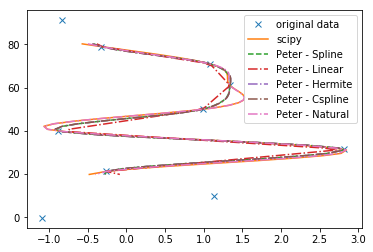

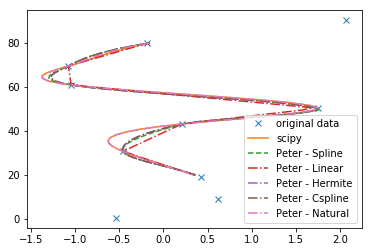

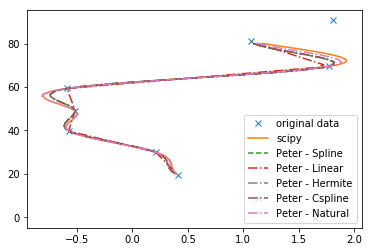

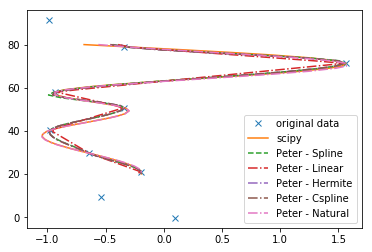

In [27]:
import numpy as np
import warnings

def along_axis(y, x, newx, axis, inverse=False, method='linear'):
    """ Interpolate vertical profiles, e.g. of atmospheric variables
    using vectorized numpy operations

    - This function assumes that the x-xoordinate increases monotonically

    args
    ----
    y : nd-array
        The variable to be interpolated
    x : nd-array or 1d-array
        The coordinate associated with y, along which to interpolate.
        If nd-array, this variable should have the same shape as y
        If 1d, len(x) should be equal to the length of y along `axis`
    newx : nd-array or 1d-array or float
           The new coordinates to which y should be interpolated.
           If nd-array, this variable should have the same shape as y
           If 1d, len(x) should be equal to the length of y along `axis`
    method : string
             'linear', straightforward linear interpolation
             'cubic', Algorithm from: http://www.paulinternet.nl/?page=bicubic
                    f(x) = ax**3+bx**2+cx+d with
                    a = 2f(0) - 2f(1) + f'(0) + f'(1)
                    b = -3f(0) + 3f(1) - 2f'(0) - f'(1)
                    c = f'(0)
                    d = f(0)

             'hermite', Algorithm from https://en.wikipedia.org/wiki/Cubic_Hermite_spline
                    f(x) = h00(x)*f(0)+h10(x)*f'(0)+h01(x)*f(1)+h11(x)*f'(1) with
                    h00(x) = 2x**3-3x**2+1
                    h10(x) = x**3-2x**2+x
                    h01(x) = -2x**3+3x**2
                    h11(x) = x**3-x**2

             'cspline', Algorithm from https://en.wikipedia.org/wiki/Spline_interpolation
                    f(x) = (1-x)*f(0) + x*f(1) + x*(1-x)*(a*(10x)+bx) with
                    a = f'(0)*(x_up-x_low) - (f(1)-f(0))
                    a = -f'(1)*(x_up-x_low) + (f(1)-f(0))

            'natural', Algorithm from https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation#Methods
                    ddf0*a**3/(6*c) + ddf1*b**3/(6*c) + (y0-ddf0*c**2/6)*a/c + y1-ddf1*c**2/6)*b/c
                    a = x1 - x
                    b = x - x0
                    c = x1 - x0
                    where ddf is solved for using TDMA.

    Notes
    -----
    * Updated to work with irregularly spaced x-coordinate.
    * Updated to work with irregularly spaced newx-coordinate
    * Updated to easily inverse the direction of the x-coordinate
    * Updated to fill with nans outside extrapolation range
    * Updated to include a linear interpolation method as well
        (it was initially written for a cubic function)
    * Updated for https://github.com/numpy/numpy/pull/9686 (makes it ugly!)
    * Updated to work with either 1d or nd input for x and newx.
    * Added two new algorithms for computing a cubic spline: 'hermite' and 'cspline'
      Theoretically, they should yield the same results, but it seems to work better than the old method 'cubic'
    * Added option 'gradient', which let you choose between numpy and a cardinal gradient computation.
    * Added option 'c': the tension parameter of the cardinal gradient computation.
    * Added method 'natural', but this seems to work less well. Should it be implemented differently?
      perhaps using tridiagonal matrix, like here: https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation#Methods
    * Fixed the 'natural' spline interpolation. This method is (nearly) equivalent to the
      scipy routine. It finds the optimal curvature at each node under the condition that
      the curvature is 0 at the start and end points. It uses Thomas' algorithm to solve
      a tridiagonal matrix for the curvature at the nodes. This involves two extra loops
      over the target axis, but it's probably still faster than applied scipy1d recursively.
    * Removed gradient option - fall back to numpy defaults. Cardinal gradient computation
      did not improve the results substantially, but did complicate the code and call


    Peter Kalverla
    March 2018; last update: October 3, 2018

    """
    # Parse input
    # -----------
    _y = np.atleast_1d(y)
    _x = np.atleast_1d(x)
    _newx = np.atleast_1d(newx)

    # This should make the shapes compatible
    _x = np.broadcast_to(_x, _y.shape)
    newshape = list(_y.shape)
    newshape[axis] = len(_newx) if _newx.ndim==1 else _newx.shape[axis]
    _newx = np.broadcast_to(_newx, newshape)

    # View of x and y with axis as first dimension
    _y = np.moveaxis(_y, axis, 0)
    _x = np.moveaxis(_x, axis, 0)
    _newx = np.moveaxis(_newx, axis, 0)

    # Possibly inverse the arrays
    if inverse:
        _y = _y[::-1]
        _x = _x[::-1]
        _newx = _newx[::-1]

    # Sanity checks: valid interpolation range and monotonic increase?
    if np.any(_newx[0] < _x[0]) or np.any(_newx[-1] > _x[-1]):
        warnings.warn("Some values are outside the interpolation range. "
                      "These will be filled with NaN")
    if np.any(np.diff(_x, axis=0) < 0):
        raise ValueError('x should increase monotonically')
    if np.any(np.diff(_newx, axis=0) < 0):
        raise ValueError('newx should increase monotonically')

    ##################################################################
    # Preprocessing: different methods need various 'helper' arrays
    if method=='linear':
        pass
    elif method=='cubic':
        # This algorithm needs a scaled gradient, so don't divide by grid spacing
        ydx = np.gradient(_y, axis=0, edge_order=2)
    elif method in ['hermite', 'cspline']:
        # The other cubic spline algorithms implement their own correction for affine transformation
        ydx = np.gradient(_y, axis=0, edge_order=2) / np.gradient(_x, axis=0, edge_order=2)
    elif method=='natural':
        # Initialize arrays for tridiagonal matrix algorithm
        # a*ddf(i-1) + b*ddf(i) + c*ddf(i+1) = d ; r is a shorthand that returns often later on
        a = np.zeros_like(_x)
        b = np.zeros_like(_x) + 2
        # c = 1-a, don't need to contaminate memory for that
        d = np.zeros_like(_x)
        ddf = np.zeros_like(_x)
        r = np.zeros_like(_x)

        # Type II "natural" BC:
        a[0] = a[-1] = 0
        d[0] = d[-1] = 0
        ddf[0] = ddf[-1] = 0

        r[1:] = _x[1:]-_x[:-1]
        a[1:-1] = r[1:-1]/(r[1:-1] + r[2:])
        d[1:-1] = 6*np.diff(np.diff(_y, axis=0)/r[1:,...], axis=0)/(_x[2:]-_x[:-2])

        # Available alternatives: TMDASolve, TMDAsolver, TMDAsolver2,
        #                         TMDAsolver3, TMDA, TMDA2 (see below)
        ddf = TDMAsolver3(a, b, 1-a, d)

    else:
        raise ValueError("interpolation method not understood (got %s)"
                         "(choose 'linear', 'cubic', 'hermite', 'cspline', or 'natural')"%method)

    ##################################################################
    # Initialize indexer arrays

    # This will later be concatenated with a dynamic '0th' index
    ind = [i for i in np.indices(_y.shape[1:])]

    # Allocate the output array
    original_dims = _y.shape
    newdims = list(original_dims)
    newdims[0] = len(_newx)
    newy = np.zeros(newdims)

    # set initial bounds
    i_lower = np.zeros(_x.shape[1:], dtype=int)
    i_upper = np.ones(_x.shape[1:], dtype=int)
    x_lower = _x[0, ...]
    x_upper = _x[1, ...]

    ##################################################################
    # Pass trough the array along <axis> and evaluate f(x) at _newx
    for i, xi in enumerate(_newx):
        # Start at the 'bottom' of the array and work upwards
        # This only works if x and newx increase monotonically

        # Update bounds where necessary and possible
        needs_update = (xi > x_upper) & (i_upper+1<len(_x))
        # print x_upper.max(), np.any(needs_update)
        while np.any(needs_update):
            i_lower = np.where(needs_update, i_lower+1, i_lower)
            i_upper = i_lower + 1
            x_lower = _x[tuple([i_lower]+ind)]
            x_upper = _x[tuple([i_upper]+ind)]

            # Check again
            needs_update = (xi > x_upper) & (i_upper+1<len(_x))

        # Express the position of xi relative to its neighbours (i.e. affine transformation)
        # Note: this requires that the gradient is scaled with (x_upper-x_lower).
        xj = (xi-x_lower)/(x_upper - x_lower)

        # Determine where there is a valid interpolation range
        within_bounds = (_x[0, ...] < xi) & (xi < _x[-1, ...])

        # Get the current index values of helper arrays
        y0, y1 = _y[tuple([i_lower]+ind)], _y[tuple([i_upper]+ind)]
        if method in ['cubic', 'hermite', 'cspline']:
            dy0, dy1 = ydx[tuple([i_lower]+ind)], ydx[tuple([i_upper]+ind)]
        elif method == 'natural':
            ddf0, ddf1 = ddf[tuple([i_lower]+ind)], ddf[tuple([i_upper]+ind)]
            ri = r[tuple([i_upper]+ind)]

        # Calculate interpolated function values
        if method == 'linear':
            a = y1 - y0
            b = y0
            newy[i, ...] = np.where(within_bounds, a*xj+b, np.nan)

        elif method=='cubic':
            # http://www.paulinternet.nl/?page=bicubic
            a = 2*y0 - 2*y1 + dy0 + dy1
            b = -3*y0 + 3*y1 - 2*dy0 - dy1
            c = dy0
            d = y0
            newy[i, ...] = np.where(within_bounds, a*xj**3 + b*xj**2 + c*xj + d, np.nan)

        elif method=='hermite':
            # https://en.wikipedia.org/wiki/Cubic_Hermite_spline
            h00 = 2*xj**3 - 3*xj**2 + 1
            h10 = xj**3 - 2*xj**2 + xj
            h01 = -2*xj**3 + 3*xj**2
            h11 = xj**3 - xj**2
            scale = x_upper - x_lower
            newy[i, ...] = np.where(within_bounds, h00*y0 + h10*scale*dy0 + h01*y1 + h11*scale*dy1, np.nan)

        elif method=='cspline':
            # https://en.wikipedia.org/wiki/Cubic_Hermite_spline
            a = dy0*(x_upper - x_lower) - (y1-y0)
            b = -dy1*(x_upper - x_lower) + (y1-y0)
            newy[i, ...] = np.where(within_bounds, (1-xj)*y0+xj*y1 +xj*(1-xj)*(a*(1-xj)+b*xj), np.nan)

        elif method=='natural':
            # https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation#Methods
            newy[i] = np.where(within_bounds,
                (ddf0*(x_upper-xi)**3/(6*ri) + ddf1*(xi-x_lower)**3/(6*ri)
                + (y0-ddf0*ri**2/6)*(x_upper-xi)/ri + (y1-ddf1*ri**2/6)*(xi-x_lower)/ri),
                np.nan)

    ##################################################################
    # Prepare for exit
    if inverse:
        newy = newy[::-1, ...]

    return np.moveaxis(newy, 0, axis)

################# Solvers ######################
# https://stackoverflow.com/a/23133208/6012085
def TDMASolve(a, b, c, d):
    n = len(d) # n is the numbers of rows, a and c has length n-1
    a = a[1:]  # edited by Peter (I guess that's meant by the above comment about len(a))
    c = c[:-1] # edited by Peter (I guess that's meant by the above comment about len(c))
    for i in range(n-1):
        d[i+1] -= 1. * d[i] * a[i] / b[i]
        b[i+1] -= 1. * c[i] * a[i] / b[i]
    for i in reversed(range(n-1)):
        d[i] -= d[i+1] * c[i] / b[i+1]
    return d/b # edited by Peter (using numpy rather than python list comprehension)

# https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]
    xc = bc
    xc[-1] = dc[-1]/bc[-1]
    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
    return xc

# https://gist.github.com/ofan666/1875903
def TDMAsolver2(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    nf = len(a)     # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d))     # copy the array
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]
    xc = ac
    xc[-1] = dc[-1]/bc[-1]
    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
    del bc, cc, dc  # delete variables from memory
    return xc

# https://gist.github.com/ofan666/1875903 (simplified by peter)
def TDMAsolver3(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    x = np.zeros_like(a) # output array
    nf = len(a)     # number of equations
    # Forward sweep
    for i in range(1, nf):
        m = a[i]/b[i-1]
        b[i] = b[i] - m*c[i-1]
        d[i] = d[i] - m*d[i-1]
    x[-1] = d[-1]/b[-1]
    # Backward fill
    for i in range(nf-2, -1, -1):
        x[i] = (d[i]-c[i]*x[i+1])/b[i]
    return x


# Own routine (combination of the above)
def TDMA(a, b, c, d):
    x = np.zeros_like(d)
    n = len(d)
    for i in range(1, n-2):
        d[i+1] -= 1. * d[i] * a[i] / b[i]
        b[i+1] -= 1. * c[i] * a[i] / b[i]
    x[-2] = d[-2] / b[-2]
    for i in reversed(range(1, n-2)):
        x[i] = (d[i]-c[i]*x[i+1])/b[i]
    return x

# Own implementation from wikipedia (this one is not working as well as the others)
def TDMA2(a, b, c, d):
    # https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    x = np.zeros_like(d)
    n = len(d)
    c[0] = c[0] / b[0]
    d[0] = d[0] / b[0]
    for i in range(1, n):
        c /= (b[i] - a[i] * c[i-1] )
        d = (d[i] - a[i]*d[i-1]) / (b[i] - a[i] * c[i-1])
    x[-1] = d[-1]
    for i in reversed(range(1, n-1)):
        x[i] = (d[i]-c[i]*x[i+1])
    return x

#########################################################


if __name__=="__main__":
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d as scipy1d

    # Check some random profiles
    for case in range(1,5):
        # toy coordinates and data
        nx, ny, nz = 25, 30, 10
        x = np.arange(nx)
        y = np.arange(ny)
        testdata = np.random.randn(nx,ny,nz) # x,y,z

        # case=1
        if case==1: # z = ndarray, znew=ndarray
            # Original z-coordinate
            z = np.tile(np.arange(nz), (nx,ny,1)) + np.random.randn(nx, ny, nz)*.1
            # Desired z-coordinates (must be between bounds of z)
            znew = np.tile(np.linspace(2,nz-2,50), (nx,ny,1)) + np.random.randn(nx, ny, 50)*0.01
        elif case==2: # z = ndarray, znew=1d array
            z = np.tile(np.arange(nz), (nx,ny,1)) + np.random.randn(nx, ny, nz)*.1
            znew = np.linspace(2, nz-2, 50) + np.random.randn(50)*0.01
        elif case==3: # z = 1d-array, znew=1d-array
            z = np.arange(nz) + np.random.randn(nz)*.1
            znew = np.linspace(2, nz-2, 50) + np.random.randn(50)*0.01
        elif case==4: # z = 1d-array, znew=nd-array
            z = np.arange(nz) + np.random.randn(nz)*.1
            znew = np.tile(np.linspace(2,nz-2,50), (nx,ny,1)) + np.random.randn(nx, ny, 50)*0.01
        # else # case==5 --> pass single float value to interpolation function.

        # Inverse the coordinates for testing (and multiply to magnify the effect of scaling)
        z = z[..., ::-1]*10
        znew = znew[..., ::-1]*10

        # Now use own routine
        ynew = along_axis(testdata, z, znew, axis=2, inverse=True, method='cubic')
        ynew2 = along_axis(testdata, z, znew, axis=2, inverse=True, method='linear')
        ynew3 = along_axis(testdata, z, znew, axis=2, inverse=True, method='hermite')
        ynew4 = along_axis(testdata, z, znew, axis=2, inverse=True, method='cspline')
        ynew5 = along_axis(testdata, z, znew, axis=2, inverse=True, method='natural')

        randx = np.random.randint(nx)
        randy = np.random.randint(ny)

        if case in [1,2]: # z = nd
            checkfunc = scipy1d(z[randx, randy], testdata[randx,randy], kind='cubic')
        else:
            checkfunc = scipy1d(z, testdata[randx,randy], kind='cubic')
        if case in [1,4]: # znew = nd
            checkdata = checkfunc(znew[randx, randy])
        else:
            checkdata = checkfunc(znew)

        fig, ax = plt.subplots()
        if case in [1,2]: # z = nd
            ax.plot(testdata[randx, randy], z[randx, randy], 'x', label='original data')
        else:
            ax.plot(testdata[randx, randy], z, 'x', label='original data')
        if case in [1,4]: # znew = nd
            ax.plot(checkdata, znew[randx, randy], label='scipy')
            ax.plot(ynew[randx, randy], znew[randx, randy], '--', label='Peter - Spline')
            ax.plot(ynew2[randx, randy], znew[randx, randy], '-.', label='Peter - Linear')
            ax.plot(ynew3[randx, randy], znew[randx, randy], '-.', label='Peter - Hermite')
            ax.plot(ynew4[randx, randy], znew[randx, randy], '-.', label='Peter - Cspline')
            ax.plot(ynew5[randx, randy], znew[randx, randy], '-.', label='Peter - Natural')
        else:
            ax.plot(checkdata, znew, label='scipy')
            ax.plot(ynew[randx, randy], znew, '--', label='Peter - Spline')
            ax.plot(ynew2[randx, randy], znew, '-.', label='Peter - Linear')
            ax.plot(ynew3[randx, randy], znew, '-.', label='Peter - Hermite')
            ax.plot(ynew4[randx, randy], znew, '-.', label='Peter - Cspline')
            ax.plot(ynew5[randx, randy], znew, '-.', label='Peter - Natural')

        ax.legend()
        plt.show()
